In [78]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

np.set_printoptions(precision=3, suppress=True)

In [79]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.9.1


In [80]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  # plt.ylim([0, 1200])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Tensile Strength, Ultimate]')
  plt.legend()
  plt.grid(True)

In [81]:
nickel_data = pd.read_csv("dataWithHeat.csv", index_col=0)

# For now we must get rid of the data without heat treatments.
# Luckily, this is shown in values with zero heat treatment 1 temp
nickel_data = nickel_data.drop(
    nickel_data[nickel_data['Heat treatment 1 Temperature'] < 3].index)

# There seems to be incorrect entries, drop them
nickel_data = nickel_data.drop(
    nickel_data[nickel_data['Heat treatment 2 Temperature'] > 7599].index)
# TODO: Check that this is alright
# nickel_data = nickel_data.drop(
    # nickel_data[nickel_data['Tensile Strength, Ultimate'] < 100].index)


# Drop the names column
nickel_data = nickel_data.drop(columns="Name")

nickel_data.head()


,"Tensile Strength, Yield",Heat treatment 1 Temperature,Heat treatment 1 Time,Heat treatment 2 Temperature,Heat treatment 2 Time,Heat treatment 3 Temperature,Heat treatment 3 Time,Heat treatment 4 Temperature,Heat treatment 4 Time,Heat treatment 5 Temperature,...,Ta,Ti,V,W,Y,Th,O,Zr,"Tensile Strength, Ultimate",Elongation at Break
0,989.0,954.0,1.0,788.0,8.0,704.0,8,760.0,500,0,...,0.0,0.7,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN
1,NaN,1121.0,0.0,0.0,0.0,0.0,0,0.0,0,0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,845.0,NaN
2,NaN,1232.0,0.0,0.0,0.0,0.0,0,0.0,0,0,...,0.0,0,0.0,14.0,0.0,0.0,0.0,0.0,NaN,NaN
3,NaN,1010.0,4.0,843.0,4.0,760.0,16,0.0,0,0,...,0.0,3,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
5,1074.0,1149.0,1.0,700.0,16.0,0.0,0,0.0,0,0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,26.4


## Train UTS Model

In [82]:
uts_data = nickel_data.dropna(subset="Tensile Strength, Ultimate")
uts_data = uts_data.drop(
    columns=['Tensile Strength, Yield', 'Elongation at Break'])
uts_data = uts_data.fillna(0)
uts_data = uts_data.astype("float32")

uts_train_data = uts_data.sample(frac=0.8, random_state=6225)
uts_test_data = uts_data.drop(uts_train_data.index)

uts_data.head()

,Heat treatment 1 Temperature,Heat treatment 1 Time,Heat treatment 2 Temperature,Heat treatment 2 Time,Heat treatment 3 Temperature,Heat treatment 3 Time,Heat treatment 4 Temperature,Heat treatment 4 Time,Heat treatment 5 Temperature,Heat treatment 5 Time,...,Si,Ta,Ti,V,W,Y,Th,O,Zr,"Tensile Strength, Ultimate"
1,1121.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.40,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,845.0
11,1160.0,4.0,1080.0,4.0,850.0,24.0,760.0,16.0,0.0,0.0,...,0.02,0.0,3.45,0.0,0.0,0.0,0.0,0.0,0.0,1466.0
13,1121.0,1.0,843.0,4.0,718.0,8.0,621.0,8.0,0.0,0.0,...,0.06,0.0,0.20,0.0,0.0,0.0,0.0,0.0,0.0,816.0
24,1288.0,4.0,1079.0,4.0,871.0,16.0,0.0,0.0,0.0,0.0,...,0.00,12.0,1.50,0.0,4.0,0.0,0.0,0.0,0.0,1140.0
25,982.0,1.0,843.0,3.0,718.0,8.0,621.0,8.0,0.0,0.0,...,0.09,0.0,1.68,0.0,0.0,0.0,0.0,0.0,0.0,1372.0


In [83]:
uts_train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Heat treatment 1 Temperature,642.0,1071.706299,114.885963,704.0,982.000000,1100.000000,1160.0000,1316.000000
Heat treatment 1 Time,642.0,10.236760,52.849930,0.0,1.000000,2.000000,4.0000,1175.000000
Heat treatment 2 Temperature,642.0,711.481812,339.944824,0.0,718.000000,788.000000,855.2500,1185.000000
Heat treatment 2 Time,642.0,16.696262,136.246460,0.0,1.000000,4.000000,8.0000,2000.000000
Heat treatment 3 Temperature,642.0,460.876068,383.645538,0.0,0.000000,621.111084,760.0000,1185.000000
Heat treatment 3 Time,642.0,17.267912,82.523315,0.0,0.000000,8.000000,16.0000,760.000000
Heat treatment 4 Temperature,642.0,113.704910,264.401093,0.0,0.000000,0.000000,0.0000,871.000000
Heat treatment 4 Time,642.0,31.904984,211.272675,0.0,0.000000,0.000000,0.0000,1500.000000
Heat treatment 5 Temperature,642.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000
Heat treatment 5 Time,642.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000


In [84]:
uts_train_features = uts_train_data.copy()
uts_test_features = uts_test_data.copy()

uts_train_labels = uts_train_features.pop("Tensile Strength, Ultimate")
uts_test_labels = uts_test_features.pop("Tensile Strength, Ultimate")

In [85]:
uts_normalizer = tf.keras.layers.Normalization(axis=-1)
uts_normalizer.adapt(np.array(uts_train_features))

In [86]:
first = np.array(uts_train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', uts_normalizer(first).numpy())

First example: [[1191.      4.    843.      4.    760.      4.      0.      0.      0.
     0.      3.64    0.03    0.06   17.66   12.47    0.      0.      0.
     0.      0.      0.      3.96    0.      1.9    55.95    0.      0.
     0.      0.      0.      4.28    0.      0.02    0.      0.      0.
     0.03]]

Normalized: [[ 1.04 -0.12  0.39 -0.09  0.78 -0.16 -0.43 -0.15  0.    0.    0.78  1.12
   0.06  1.13 -0.72 -0.34 -0.64 -0.06  0.    2.42 -0.38  0.25 -0.12  0.14
   0.01 -0.29  0.    0.   -0.53 -0.38  1.3  -0.14 -0.5   0.    0.    0.
   0.07]]


### First try with a linear model (For sanity)

In [87]:
linear_model = tf.keras.Sequential([
    uts_normalizer,
    layers.Dense(units=1)
])

linear_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 37)               75        
 ion)                                                            
                                                                 
 dense_17 (Dense)            (None, 1)                 38        
                                                                 
Total params: 113
Trainable params: 38
Non-trainable params: 75
_________________________________________________________________


In [88]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


In [89]:
%%time
history = linear_model.fit(
    uts_train_features,
    uts_train_labels,
    epochs=1000,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split=0.2)

# print(history.history["val_loss"])

CPU times: total: 35.6 s
Wall time: 26.9 s


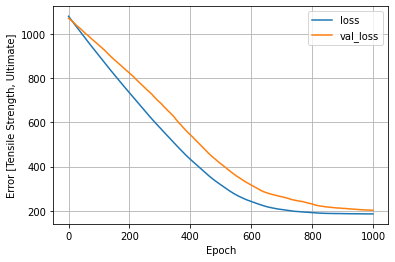

In [90]:
plot_loss(history)

### Now train a NN model

In [91]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(25, activation='relu'),
      layers.Dense(25, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [92]:
dnn_model = build_and_compile_model(uts_normalizer)
dnn_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 37)               75        
 ion)                                                            
                                                                 
 dense_18 (Dense)            (None, 25)                950       
                                                                 
 dense_19 (Dense)            (None, 25)                650       
                                                                 
 dense_20 (Dense)            (None, 1)                 26        
                                                                 
Total params: 1,701
Trainable params: 1,626
Non-trainable params: 75
_________________________________________________________________


In [93]:
%%time
history = dnn_model.fit(
    uts_train_features,
    uts_train_labels,
    validation_split=0.2,
    verbose=0, epochs=1000)

CPU times: total: 46.1 s
Wall time: 27.7 s


In [94]:
dnn_model.evaluate(uts_test_features, uts_test_labels, verbose=0)

174.85670471191406

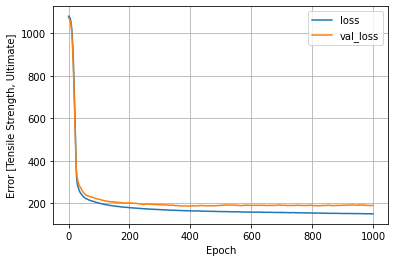

In [95]:
plot_loss(history)

5/5 [==============================] - 0s 751us/step


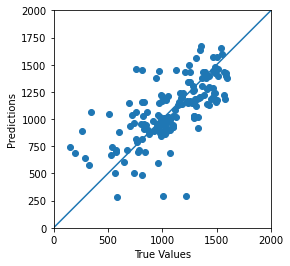

In [96]:
test_predictions = dnn_model.predict(uts_test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(uts_test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 2000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## Train Yield Model

In [97]:
yield_data = nickel_data.dropna(subset='Tensile Strength, Yield')
yield_data = yield_data.drop(
    columns=["Tensile Strength, Ultimate", 'Elongation at Break'])
yield_data = yield_data.fillna(0)
yield_data = yield_data.astype("float32")

yield_train_data = yield_data.sample(frac=0.8, random_state=1234)
yield_test_data = yield_data.drop(yield_train_data.index)

yield_data.head()

,"Tensile Strength, Yield",Heat treatment 1 Temperature,Heat treatment 1 Time,Heat treatment 2 Temperature,Heat treatment 2 Time,Heat treatment 3 Temperature,Heat treatment 3 Time,Heat treatment 4 Temperature,Heat treatment 4 Time,Heat treatment 5 Temperature,...,Ru,Si,Ta,Ti,V,W,Y,Th,O,Zr
0,989.0,954.0,1.0,788.0,8.0,704.0,8.0,760.0,500.0,0.0,...,0.0,0.00,0.0,0.70,0.0,1.00,0.0,0.0,0.0,0.000
5,1074.0,1149.0,1.0,700.0,16.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.000
12,260.0,1177.0,1.0,816.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.50,0.0,0.00,0.0,2.50,0.0,0.0,0.0,0.000
14,1581.0,1175.0,2.0,760.0,8.0,649.0,24.0,0.0,0.0,0.0,...,0.0,0.00,0.0,5.00,0.0,1.25,0.0,0.0,0.0,0.035
16,518.0,982.0,1.0,622.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.07,0.0,0.27,0.0,0.00,0.0,0.0,0.0,0.000


In [98]:
yield_train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
"Tensile Strength, Yield",746.0,810.085266,305.050690,40.0,617.250000,835.500000,1018.750,1654.000000
Heat treatment 1 Temperature,746.0,1201.092285,503.153015,704.0,1020.000000,1121.000000,1175.000,3812.399902
Heat treatment 1 Time,746.0,4.580764,8.742323,0.0,1.000000,2.000000,4.000,50.000000
Heat treatment 2 Temperature,746.0,786.960266,491.427490,0.0,704.000000,799.000000,871.000,2327.399902
Heat treatment 2 Time,746.0,23.741957,172.520065,0.0,2.000000,6.000000,8.000,2000.000000
Heat treatment 3 Temperature,746.0,466.291443,517.581909,0.0,0.000000,621.000000,760.000,2012.400024
Heat treatment 3 Time,746.0,12.404826,64.688095,0.0,0.000000,8.000000,16.000,1000.000000
Heat treatment 4 Temperature,746.0,78.270775,221.065338,0.0,0.000000,0.000000,0.000,843.000000
Heat treatment 4 Time,746.0,6.372654,50.450592,0.0,0.000000,0.000000,0.000,1000.000000
Heat treatment 5 Temperature,746.0,5.093834,62.052628,0.0,0.000000,0.000000,0.000,760.000000


In [99]:
yield_train_features = yield_train_data.copy()
yield_test_features = yield_test_data.copy()

yield_train_labels = yield_train_features.pop('Tensile Strength, Yield')
yield_test_labels = yield_test_features.pop('Tensile Strength, Yield')

yield_train_features.head()

,Heat treatment 1 Temperature,Heat treatment 1 Time,Heat treatment 2 Temperature,Heat treatment 2 Time,Heat treatment 3 Temperature,Heat treatment 3 Time,Heat treatment 4 Temperature,Heat treatment 4 Time,Heat treatment 5 Temperature,Heat treatment 5 Time,...,Ru,Si,Ta,Ti,V,W,Y,Th,O,Zr
575,1175.000000,2.0,760.000000,8.0,649.000000,24.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,5.00,0.0,1.25,0.0,0.0,0.0,0.035
2226,3092.399902,1.0,2327.399902,8.0,2012.400024,8.0,0.0,0.0,0.0,0.0,...,0.0,0.60,0.00,0.37,0.0,0.00,0.0,0.0,0.0,0.000
2357,1052.000000,1.0,816.000000,4.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,4.02,2.07,0.0,2.17,0.0,0.0,0.0,0.000
97,3452.399902,1.0,2327.399902,8.0,2012.400024,8.0,0.0,0.0,0.0,0.0,...,0.0,0.61,0.00,1.45,0.0,0.00,0.0,0.0,0.0,0.000
1580,1168.000000,2.0,0.000000,1121.0,760.000000,8.0,649.0,24.0,0.0,0.0,...,0.0,0.00,0.00,5.04,0.0,1.20,0.0,0.0,0.0,0.000


In [100]:
yield_normalizer = tf.keras.layers.Normalization(axis=-1)
yield_normalizer.adapt(np.array(yield_train_features).astype('float32'))


In [101]:
first = np.array(yield_train_features[:1]).astype('float32')

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', yield_normalizer(first).numpy())

First example: [[1175.      2.    760.      8.    649.     24.      0.      0.      0.
     0.      2.5     0.02    0.03   14.75   16.      0.      0.      0.
     0.      0.      0.      3.      0.      0.     57.41    0.      0.
     0.      0.      0.      5.      0.      1.25    0.      0.      0.
     0.04]]

Normalized: [[-0.05 -0.3  -0.05 -0.09  0.35  0.18 -0.35 -0.13 -0.08 -0.08  0.24  0.66
  -0.72  0.79 -0.   -0.04 -0.62 -0.29 -0.11 -0.08 -0.41 -0.24 -0.11 -0.75
   0.11 -0.32  0.    0.   -0.54 -0.39  1.84 -0.11 -0.03 -0.14 -0.07 -0.15
   0.5 ]]


### First try with a linear model (For sanity)

In [102]:
linear_model = tf.keras.Sequential([
    yield_normalizer,
    layers.Dense(units=1)
])

linear_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_6 (Normalizat  (None, 37)               75        
 ion)                                                            
                                                                 
 dense_21 (Dense)            (None, 1)                 38        
                                                                 
Total params: 113
Trainable params: 38
Non-trainable params: 75
_________________________________________________________________


In [103]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


In [104]:
%%time
history = linear_model.fit(
    yield_train_features,
    yield_train_labels,
    epochs=1000,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split=0.2)

# print(history.history["val_loss"])

CPU times: total: 37 s
Wall time: 27.5 s


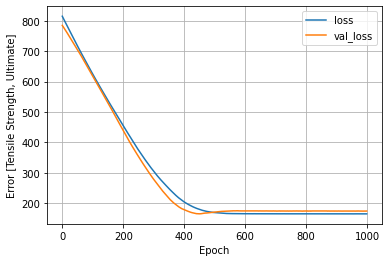

In [105]:
plot_loss(history)

### Now train a NN model

In [106]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(25, activation='relu'),
      layers.Dense(25, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [107]:
dnn_model = build_and_compile_model(yield_normalizer)
dnn_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_6 (Normalizat  (None, 37)               75        
 ion)                                                            
                                                                 
 dense_22 (Dense)            (None, 25)                950       
                                                                 
 dense_23 (Dense)            (None, 25)                650       
                                                                 
 dense_24 (Dense)            (None, 1)                 26        
                                                                 
Total params: 1,701
Trainable params: 1,626
Non-trainable params: 75
_________________________________________________________________


In [108]:
%%time
history = dnn_model.fit(
    yield_train_features,
    yield_train_labels,
    validation_split=0.2,
    verbose=0, epochs=1000)

CPU times: total: 49.5 s
Wall time: 31 s


In [109]:
dnn_model.evaluate(yield_test_features, yield_test_labels, verbose=0)

157.31777954101562

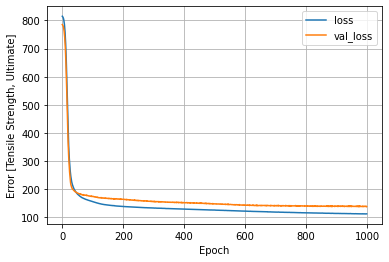

In [110]:
plot_loss(history)

6/6 [==============================] - 0s 801us/step


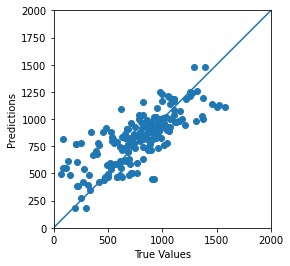

In [111]:
test_predictions = dnn_model.predict(yield_test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(yield_test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 2000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## Train Elongation Model

In [112]:
elong_data = nickel_data.dropna(subset='Elongation at Break')
elong_data = elong_data.drop(
    columns=["Tensile Strength, Ultimate", 'Tensile Strength, Yield'])
elong_data = elong_data.fillna(0)
elong_data = elong_data.astype("float32")


elong_train_data = elong_data.sample(frac=0.8, random_state=4321)
elong_test_data = elong_data.drop(elong_train_data.index)

elong_data.head()

,Heat treatment 1 Temperature,Heat treatment 1 Time,Heat treatment 2 Temperature,Heat treatment 2 Time,Heat treatment 3 Temperature,Heat treatment 3 Time,Heat treatment 4 Temperature,Heat treatment 4 Time,Heat treatment 5 Temperature,Heat treatment 5 Time,...,Si,Ta,Ti,V,W,Y,Th,O,Zr,Elongation at Break
5,1149.0,1.0,700.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.000,26.400000
12,1177.0,1.0,816.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.50,0.0,0.00,0.0,2.50,0.0,0.0,0.0,0.000,30.000000
14,1175.0,2.0,760.0,8.0,649.0,24.0,0.0,0.0,0.0,0.0,...,0.00,0.0,5.00,0.0,1.25,0.0,0.0,0.0,0.035,17.299999
16,982.0,1.0,622.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.07,0.0,0.27,0.0,0.00,0.0,0.0,0.0,0.000,47.000000
20,1160.0,4.0,1080.0,4.0,850.0,24.0,760.0,16.0,0.0,0.0,...,0.04,0.0,3.57,0.0,0.00,0.0,0.0,0.0,0.000,2.600000


In [113]:
elong_train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Heat treatment 1 Temperature,638.0,1220.120361,547.281677,704.0,1020.00000,1121.0000,1169.500000,3812.399902
Heat treatment 1 Time,638.0,4.666144,9.088142,0.0,1.00000,2.0000,4.000000,50.000000
Heat treatment 2 Temperature,638.0,807.923889,516.221924,0.0,718.00000,800.0000,955.000000,2327.399902
Heat treatment 2 Time,638.0,26.820534,186.395065,0.0,2.00000,6.0000,8.000000,2000.000000
Heat treatment 3 Temperature,638.0,480.122894,538.447449,0.0,0.00000,621.0000,760.000000,2012.400024
Heat treatment 3 Time,638.0,13.722570,69.839035,0.0,0.00000,8.0000,16.000000,1000.000000
Heat treatment 4 Temperature,638.0,82.036049,224.581299,0.0,0.00000,0.0000,0.000000,843.000000
Heat treatment 4 Time,638.0,3.047022,39.780178,0.0,0.00000,0.0000,0.000000,1000.000000
Heat treatment 5 Temperature,638.0,3.573668,52.033260,0.0,0.00000,0.0000,0.000000,760.000000
Heat treatment 5 Time,638.0,0.037618,0.547719,0.0,0.00000,0.0000,0.000000,8.000000


In [114]:
elong_train_features = elong_train_data.copy()
elong_test_features = elong_test_data.copy()

elong_train_labels = elong_train_features.pop('Elongation at Break')
elong_test_labels = elong_test_features.pop('Elongation at Break')


In [115]:
elong_normalizer = tf.keras.layers.Normalization(axis=-1)
elong_normalizer.adapt(np.array(elong_train_features).astype('float32'))


In [116]:
first = np.array(elong_train_features[:1]).astype('float32')

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', elong_normalizer(first).numpy())


First example: [[1024.     1.5  941.     4.   843.     7.     0.     0.     0.     0.
     0.5    0.     0.     0.    18.5    0.    18.5    0.     0.     0.
     0.     3.     0.     5.    53.4    0.     0.     0.     0.     0.
     1.     0.     0.     0.     0.     0.     0. ]]

Normalized: [[-0.36 -0.35  0.26 -0.12  0.67 -0.1  -0.37 -0.08 -0.07 -0.07 -0.89 -0.61
  -1.37 -1.08  0.49 -0.06  0.91 -0.3  -0.1   0.   -0.42 -0.17 -0.13  1.59
  -0.21 -0.3   0.    0.   -0.57 -0.38 -0.71 -0.12 -0.51 -0.14 -0.09 -0.17
  -0.68]]


### First try with a linear model (For sanity)

In [117]:
linear_model = tf.keras.Sequential([
    elong_normalizer,
    layers.Dense(units=1)
])

linear_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_7 (Normalizat  (None, 37)               75        
 ion)                                                            
                                                                 
 dense_25 (Dense)            (None, 1)                 38        
                                                                 
Total params: 113
Trainable params: 38
Non-trainable params: 75
_________________________________________________________________


In [118]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


In [119]:
%%time
history = linear_model.fit(
    elong_train_features,
    elong_train_labels,
    epochs=1000,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split=0.2)

# print(history.history["val_loss"])

CPU times: total: 33.7 s
Wall time: 25 s


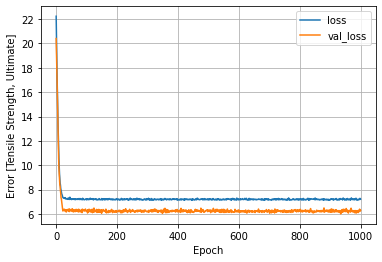

In [120]:
plot_loss(history)

### Now train a NN model

In [121]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(25, activation='relu'),
      layers.Dense(25, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [122]:
dnn_model = build_and_compile_model(elong_normalizer)
dnn_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_7 (Normalizat  (None, 37)               75        
 ion)                                                            
                                                                 
 dense_26 (Dense)            (None, 25)                950       
                                                                 
 dense_27 (Dense)            (None, 25)                650       
                                                                 
 dense_28 (Dense)            (None, 1)                 26        
                                                                 
Total params: 1,701
Trainable params: 1,626
Non-trainable params: 75
_________________________________________________________________


In [123]:
%%time
history = dnn_model.fit(
    elong_train_features,
    elong_train_labels,
    validation_split=0.2,
    verbose=0, epochs=1000)

CPU times: total: 43.4 s
Wall time: 27.3 s


In [124]:
dnn_model.evaluate(elong_test_features, elong_test_labels, verbose=0)

6.771499156951904

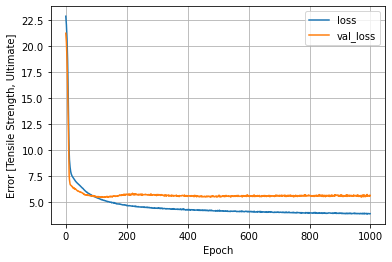

In [125]:
plot_loss(history)

5/5 [==============================] - 0s 751us/step


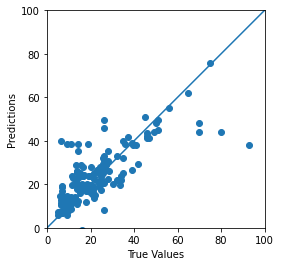

In [126]:
test_predictions = dnn_model.predict(elong_test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(elong_test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)